In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from src.data_gen import subtraction_datasets, to_ID, to_batch
from src.endeco import Encoder, Decoder

In [2]:
embedding_dim = 200
hidden_dim = 128
vocab_size = len(to_ID())

BATCH_NUM = 100
EPOCH_NUM = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
input_data, output_data = subtraction_datasets(record_num=50000)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size=0.7)

In [3]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()

In [29]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

In [30]:
print(len(train_x))
print(train_x[0])

35000
[4, 3, 11, 4, 8, 0, 10]


In [31]:
all_losses = []
print("training...")

for epoch in range(1, EPOCH_NUM + 1):
    epoch_loss = 0

    input_batch, output_batch = to_batch(train_x, train_y, batch_size=BATCH_NUM)

    for i in range(len(input_batch)):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        input_ts = torch.tensor(input_batch[i], device=device)
        output_ts = torch.tensor(output_batch[i], device=device)
        #print('input_ts.shape: ', input_ts.shape)
        
        encoder_state = encoder(input_ts)

        # last-data can not be next-input.
        training_source = output_ts[:, :-1]
        # start symbol can not ba data to train.
        training_data = output_ts[:, 1:]

        #print('training_source.shape: ', training_source.shape, ', training_data.shape: ', training_data.shape)
        loss = 0
        

        decoder_output, _ = decoder(training_source, encoder_state)

        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], training_data[:, j])

        epoch_loss += loss.item()
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    #if epoch_loss < 1: break
print("Done")

training...
Epoch 1: 0.24
Epoch 2: 0.21
Epoch 3: 0.19
Epoch 4: 0.18
Epoch 5: 0.17
Epoch 6: 0.16
Epoch 7: 0.15
Epoch 8: 0.14
Epoch 9: 0.13
Epoch 10: 0.12
Epoch 11: 0.11
Epoch 12: 0.11
Epoch 13: 0.10
Epoch 14: 0.10
Epoch 15: 0.09
Epoch 16: 0.09
Epoch 17: 0.08
Epoch 18: 0.08
Epoch 19: 0.08
Epoch 20: 0.07
Epoch 21: 0.07
Epoch 22: 0.06
Epoch 23: 0.06
Epoch 24: 0.06
Epoch 25: 0.06
Epoch 26: 0.05
Epoch 27: 0.05
Epoch 28: 0.05
Epoch 29: 0.05
Epoch 30: 0.04
Epoch 31: 0.04
Epoch 32: 0.04
Epoch 33: 0.04
Epoch 34: 0.04
Epoch 35: 0.03
Epoch 36: 0.03
Epoch 37: 0.03
Epoch 38: 0.03
Epoch 39: 0.03
Epoch 40: 0.03
Epoch 41: 0.03
Epoch 42: 0.02
Epoch 43: 0.02
Epoch 44: 0.02
Epoch 45: 0.02
Epoch 46: 0.02
Epoch 47: 0.02
Epoch 48: 0.59
Epoch 49: 0.34
Epoch 50: 0.13
Epoch 51: 0.05
Epoch 52: 0.04
Epoch 53: 0.04
Epoch 54: 0.04
Epoch 55: 0.03
Epoch 56: 0.03
Epoch 57: 0.03
Epoch 58: 0.03
Epoch 59: 0.03
Epoch 60: 0.03
Epoch 61: 0.02
Epoch 62: 0.02
Epoch 63: 0.02
Epoch 64: 0.02
Epoch 65: 0.02
Epoch 66: 0.02
Epoch 6

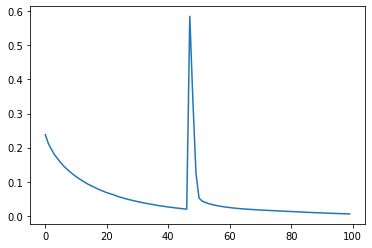

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

In [33]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データ
test_input_batch, test_output_batch = to_batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad(): # 勾配計算させない
    encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[to_ID()["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    # 変数名変換
    decoder_hidden = encoder_state

    # バッチ毎の結果を結合するための入れ物を定義
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    # print(batch_tmp.size())
    # (100,1)

    for _ in range(5):
      decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      # バッチ毎の結果を予測順に結合
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

    # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
    predicts.append(batch_tmp[:,1:])

# バッチ毎の予測結果がまとまって格納されてます。
print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 5])


In [34]:
import pandas as pd

id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[str(idx)] for idx in inp]
    y = [id2char[str(idx)] for idx in output]
    p = [id2char[str(idx.item())] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# 正解率を表示
print(len(predict_df.query('judge == "O"')) / len(predict_df))
# 0.8492
# 間違えたデータを一部見てみる
print(predict_df.query('judge == "X"').head(10))

0.86
      input answer predict judge
0    683-50    633     623     X
7   788-397    391     351     X
11  675-181    494     484     X
21   101-55     46      55     X
22   766-59    707     717     X
27  658-720    -62    -132     X
31  638-360    278     318     X
36   92-773   -681    -601     X
43   973-17    956     946     X
48  764-280    484     424     X
